# Artist Investigations

In [29]:
artist_name = "freddie gibbs".lower()

artist_frame = scrobbles[scrobbles["artist"].str.lower() == artist_name] # FILTER SCROBBLES
artist_frame = artist_frame.sort_index(ascending=False) # SORT
# artist_frame = artist_frame.loc[:, descriptor_headers] # DESCRIPTORS

total_time = artist_frame["duration_ms"].sum() / (1000 * 60) # minutes
total_days = total_time / (60 * 24) # days

print(f'{artist_frame.count()[0]:,d} scrobbles')
print(f'{total_days:.0f} days spent listening since Nov. 2017')
print(f'{total_time / days_since(first_day).days:.2f} minutes/day')

artist_frame.describe()[1:]

1,805 scrobbles
4 days spent listening since Nov. 2017
4.90 minutes/day


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
mean,0.219781,0.572843,202260.902265,0.676443,0.056700,5.447557,0.305630,-8.056303,0.698451,0.289536,110.069952,3.994636,0.512103
std,0.216312,0.160528,60373.745872,0.143114,0.191733,3.495195,0.180845,2.041763,0.459068,0.133261,32.676004,0.184284,0.198939
min,0.000512,0.256000,48507.000000,0.173000,0.000000,0.000000,0.049100,-16.918000,0.000000,0.029600,52.145000,3.000000,0.038300
25%,0.049700,0.451000,154573.000000,0.583000,0.000000,1.000000,0.139000,-9.311000,0.000000,0.203000,87.786000,4.000000,0.391000
50%,0.161000,0.543000,199053.000000,0.666000,0.000004,6.000000,0.303000,-8.328000,1.000000,0.299000,91.973000,4.000000,0.522500
75%,0.274000,0.657000,226520.000000,0.805000,0.000648,8.000000,0.399000,-6.442000,1.000000,0.380000,130.990000,4.000000,0.638000
max,0.946000,0.948000,513707.000000,0.946000,0.901000,11.000000,0.796000,-2.002000,1.000000,0.749000,188.050000,5.000000,0.959000


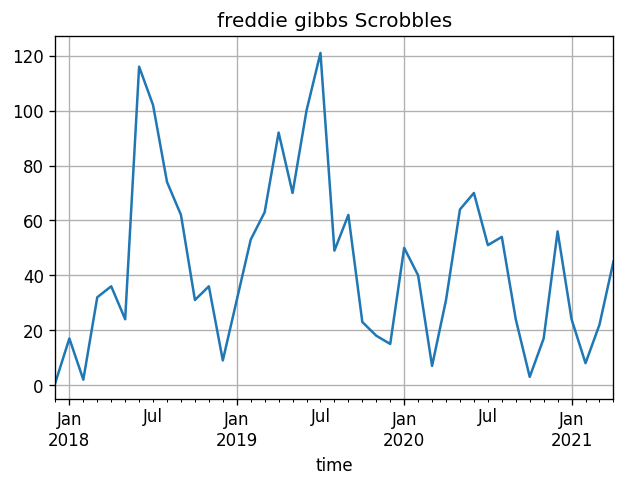

In [30]:
# resample by day and mean
artist_frame.resample("1M").count()["track"].plot()

plt.title(f"{artist_name} Scrobbles")
plt.grid()
plt.show()

## Average Descriptor

Below presents the average descriptor for the artist. "*All Listened Tracks*" describes the descriptor based on the listening activity for this artist. This takes into account how many times a track is listened to. "*Distinct Tracks*" takes only the distinct set of tracks that have been listened to and takes that average.

The difference between them could be described as which features are preferred for an artist. If the blue bar is higher than the red, it would indicate that tracks from this artist which have a higher value for this are listened to more. 

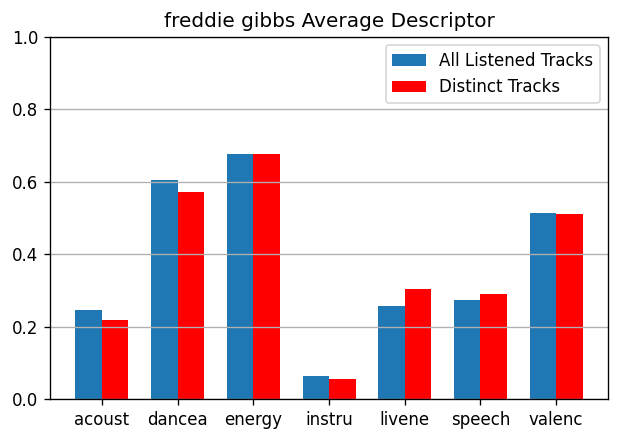

In [31]:
x = np.arange(len(float_headers))
width = 0.35

plt.bar(x - width/2, 
        artist_frame.drop_duplicates(['uri']).loc[:, float_headers].mean(), 
        width, label='All Listened Tracks')
plt.bar(x + width/2, 
        artist_frame.loc[:, float_headers].mean(), 
        width, label='Distinct Tracks', color=(1, 0, 0))

plt.title(f"{artist_name} Average Descriptor")
plt.legend(['All Listened Tracks', 'Distinct Tracks'])
plt.xticks(x, labels=[i[:6] for i in float_headers])
plt.ylim([0, 1])
plt.grid(axis='y')
plt.show()

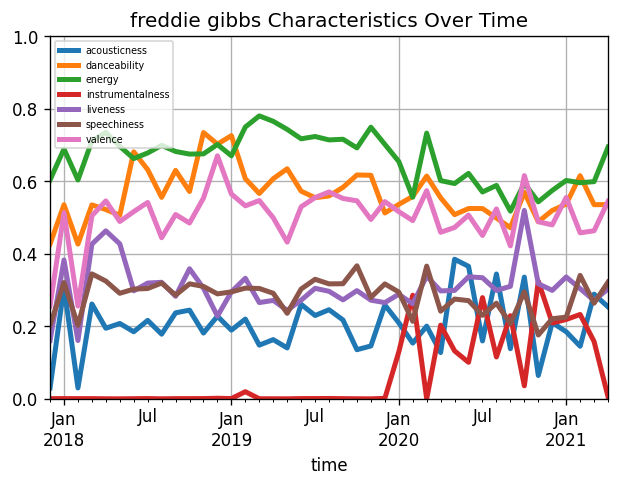

In [32]:
# select only descriptor float columns
artist_frame.loc[:, float_headers].resample("1M").mean().plot(lw=3)

plt.title(f"{artist_name} Characteristics Over Time")
plt.legend(loc = "upper left", fontsize = "xx-small")
plt.ylim([0, 1])
plt.grid()
plt.show()

# Artist Listening Time

In [33]:
LIMIT = 25
fig_size = (7,(7/20)*LIMIT)
### STATS ###

stats_frame = scrobbles.reset_index()[["track", "album", "artist", "duration_ms"]]
stats_frame = stats_frame[stats_frame["album"] != "Mirror Reaper"] # 1:30 hr long song, skews graphs

track_count = stats_frame.groupby('artist').count()["track"]
track_count.name = 'count'

duration_sum = stats_frame.groupby('artist').sum()["duration_ms"]
duration_sum.name = "duration_sum"

duration_average = stats_frame.groupby('artist').mean()["duration_ms"]
duration_average.name = "duration_mean"

track_average = stats_frame.groupby(['artist', 'track'])["album"].count()
track_average = track_average.groupby('artist').mean()
track_average.name = "track_average"

stats_frame = pd.concat([track_count, duration_sum, duration_average, track_average], axis=1).reset_index()
# stats_frame

For these charts the ordering is left as retrieved from the API, i.e by most played.

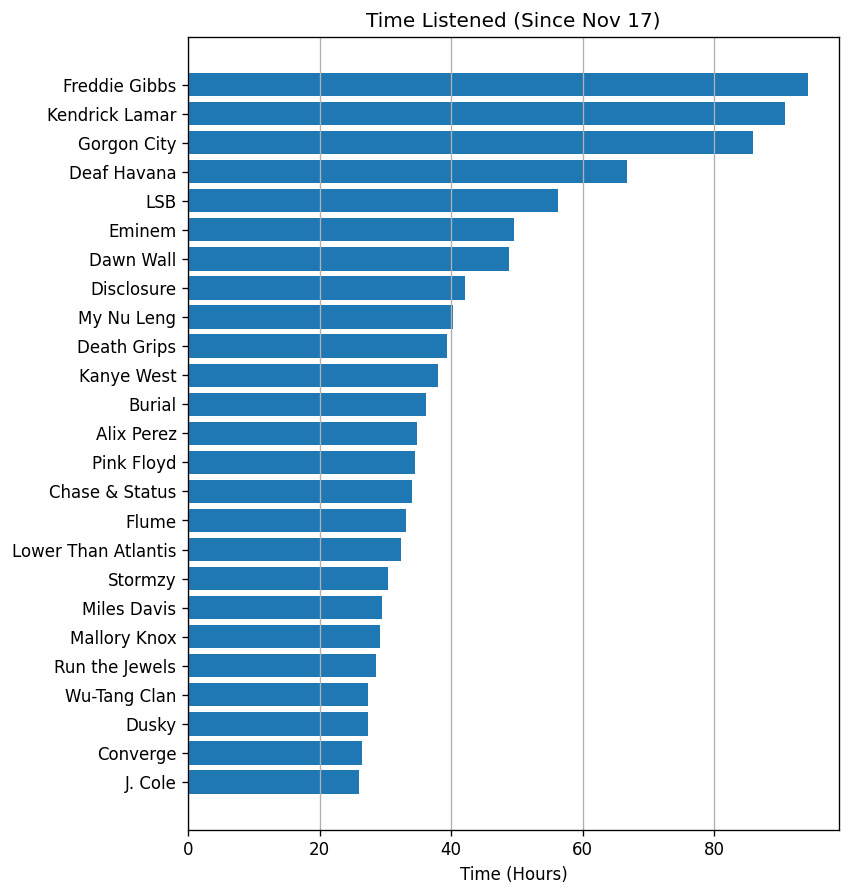

In [34]:
duration_frame = stats_frame.sort_values(by='duration_sum', ascending=False).head(LIMIT)

plt.figure(figsize=fig_size)
plt.barh(np.arange(len(duration_frame))[::-1], duration_frame["duration_sum"].to_numpy() / (1000 * 60 * 60) )
plt.yticks(np.arange(len(duration_frame))[::-1], labels=duration_frame["artist"])
plt.xlabel("Time (Hours)")
plt.grid(axis="x")
plt.title("Time Listened (Since Nov 17)")
plt.show()

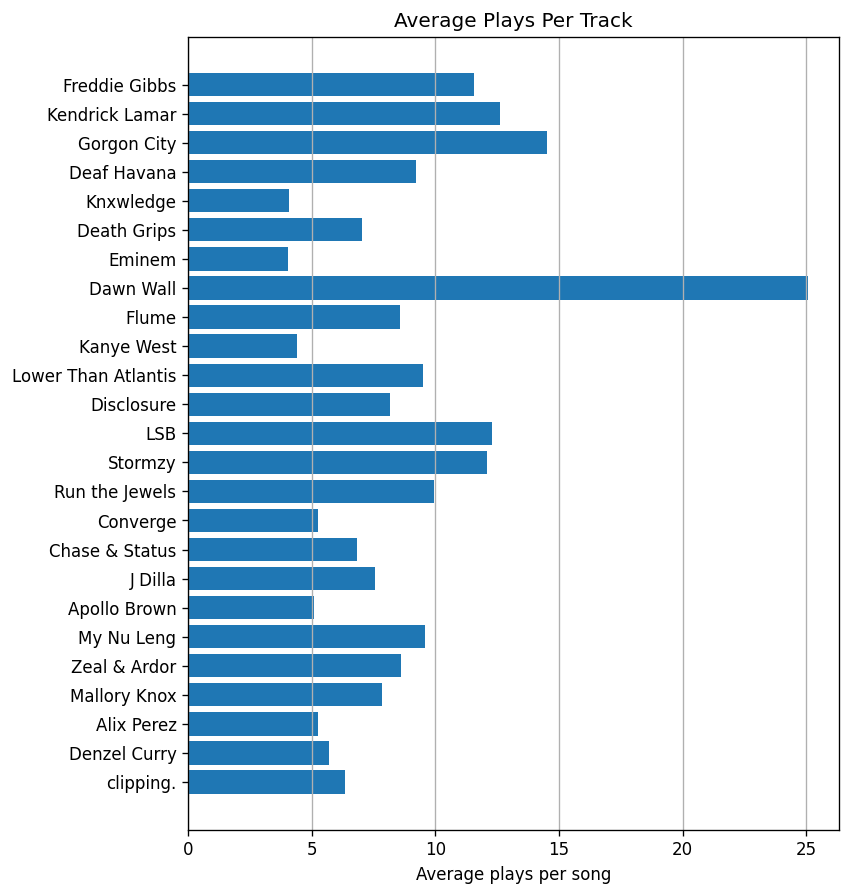

In [35]:
norm_frame = stats_frame.sort_values(by='count', ascending=False).head(LIMIT) # for top artists
# norm_frame = stats_frame.sort_values(by='track_average', ascending=False).head(LIMIT) # for one-hit wonders

plt.figure(figsize=fig_size)
plt.barh(np.arange(len(norm_frame))[::-1], norm_frame["track_average"] )
plt.yticks(np.arange(len(norm_frame))[::-1], labels=norm_frame["artist"])
plt.xlabel("Average plays per song")
plt.grid(axis="x")
plt.title("Average Plays Per Track")
plt.show()

# Imports & Setup

In [2]:
from datetime import datetime

from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

from analysis.net import get_spotnet, get_fmnet, get_playlist, track_frame
from analysis.query import *
from analysis import float_headers, days_since

import pandas as pd
import numpy as np

client = bigquery.Client()
spotnet = get_spotnet()
fmnet = get_fmnet()
cache = 'query.csv'
first_day = datetime(year=2017, month=11, day=3)

## Read Scrobble Frame

In [3]:
scrobbles = get_query(cache=cache)

## Write Scrobble Frame

In [3]:
scrobbles.reset_index().to_csv(cache, sep='\t')